# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Model parameters

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import numpy as np
import itertools
import spm1d
import scipy
import os
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
path2data = '/home/romain/Downloads/envergo/parameters/'
mat = scipy.io.loadmat(os.path.join(path2data, 'Parametres.mat'))

## Data description
- `mat['PARAMETRES']`: raw model parameters (_used in the following sections_)
    - size: $35 \text{ (participants)} \times 7 \text{ (parameters)} \times 6 \text{ (positions)} \times 2 \text{ (contractions)}$
- `mat['parametres']`: model parameters converted in _SI_ units
- `mat['ERR']`: optimization residuals

<img src="../../../Downloads/envergo//ParametresModele.png" width="800">
- Expected variables in spm: $J \text{ (observations)} \times Q \text{ (frames)} \times I \text{ (variables)}$
    - `y`: $n \times 7$
    - `A`: $n \times 1$

In [3]:
nparticipant, nparameter, nposition, ncontraction = mat['PARAMETRES'].shape
y, positions = [[] for i in range(2)]
contraction = 0  # 0: flexion | 1: extension

for iparticipant in range(nparticipant):
    for iposition in range(nposition):
        y.append(mat['PARAMETRES'][iparticipant, :, iposition, contraction])
        positions.append(iposition)

y, positions = [np.array(i) for i in [y, positions]]
print('----dimension----'.upper())
print_shape = lambda x, y: print(f'{x} shape: {y.shape} | has {np.isnan(y).sum()} over {y.shape} nans')
print_shape('y', y)
print_shape('positions', positions)

----DIMENSION----
y shape: (210, 7) | has 49 over (210, 7) nans
positions shape: (210,) | has 0 over (210,) nans


In [4]:
# replace missing trial by mean of the position
for iposition in np.unique(positions):
    idx = positions == iposition
    mean_vector = np.nanmean(y[idx, :], axis=0)
    y[idx,  :] = np.where(np.isnan(y[idx, :]), mean_vector, y[idx, :])
print_shape('y', y)
print_shape('positions', positions)

y shape: (210, 7) | has 0 over (210, 7) nans
positions shape: (210,) | has 0 over (210,) nans


In [5]:
n_positions = len(set(positions))
names_positions = ['Ref', 'Abd90IR', 'Flex90IR', 'Flex180ER', 'Abd90ER', 'Flex90ER']
names_parameters = ['Max. isometric torque', 'Max. isometric range of motion', 'Isometric optimal range', 'Velocity at max. power',
                   'Max. conc. velocity', 'Max. ecc. velocity', 'Max. ecc. to conc. torque ratio']

In [6]:
def display_results(spm, kind=None, title=None, indent=''):
    print(title.upper())
    var = 'X' if kind == 'manova' else 'T'
    if spm.h0reject:
        print(f'{indent}null hypothesis rejected, {var}2={spm.z:.3f}, p={spm.p:.5f}')
    else:
        print(f'{indent}null hypothesis not rejected')

In [7]:
def spm_heatmap(df, title=None, labels=None, save_fig=False, cmap='viridis', limits=None):
    fig, axs = plt.subplots(figsize=(8, 4))
    if limits is None:
        ax = sns.heatmap(df, linewidths=.5, cbar_kws={'label': 'T statistic'},
                     annot=True, xticklabels=labels, yticklabels=labels, cmap=cmap, fmt='g')
    else:
        ax = sns.heatmap(df, linewidths=.5, cbar_kws={'label': 'T statistic'}, vmin=limits[0], vmax=limits[1],
                     annot=True, xticklabels=labels, yticklabels=labels, cmap=cmap, fmt='g')

    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()
    
    if save_fig:
        fig.savefig('./share/fig/{}.pdf'.format(title), transparent=True)

In [8]:
import pandas as pd
names_parameters_micro = [f'P{i}'for i in range(1, y.shape[1] + 1)]
df = pd.DataFrame(y, columns=names_parameters_micro)
df['position'] = names_positions * nparticipant
df = df.melt(id_vars=['position'], var_name='parameter')
# limit outliers
df['value'] = df['value'].mask(df['value'].sub(df['value'].mean()).div(df['value'].std()).abs().gt(1))
df.head()

,position,parameter,value
0,Ref,P1,72.857916
1,Abd90IR,P1,72.857916
2,Flex90IR,P1,71.701905
3,Flex180ER,P1,59.468899
4,Abd90ER,P1,71.701905


In [9]:
from plotly import tools
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

fig = tools.make_subplots(rows=1, cols=nparameter, print_grid=False, subplot_titles=names_parameters_micro)
for iparam in range(nparameter):
    current = df[df['parameter'] == f'P{iparam + 1}']
    trace = go.Box(
        x=current['position'],
        y=current['value'],
        boxpoints='False',
    )
    fig.append_trace(trace, 1, iparam + 1)
    
    fig['layout']['font'] = dict(size=14)
py.iplot(fig)

## One-way MANOVA (non-parametric)

In [10]:
alpha = 0.05
iterations = 10000
np.random.seed(0)

m_spm = spm1d.stats.nonparam.manova1(y, positions)
m_spmi = m_spm.inference(alpha=alpha, iterations=iterations)

display_results(m_spmi, title='one-way manova', kind='manova')

ONE-WAY MANOVA
null hypothesis rejected, X2=69.606, p=0.00050


- There was a significant main effect for position ($p<0.001$)
- As the manova reaches significance, we can conduct separate Hotelling’s T$^2$ tests on each pair of groups
    - If those tests reach significance then conduct additional post hoc t tests on each vector component, but acknowledge that this neglects vector component covariance.

## Post hoc analysis (non-parametric paired Hotellings's T2 and paired t-test)

In [11]:
combinations = itertools.combinations(range(n_positions), 2)

H_heatmap = np.full([6, 6], np.nan)
T_heatmap = np.full([6, 6, 7], np.nan)
ref_heatmap = np.full([6, 6, 7], np.nan)

plot_diff = True

for A, B in combinations:
    yA = y[positions == A]
    yB = y[positions == B]
    
    h_spm = spm1d.stats.nonparam.hotellings_paired(yA, yB)
    h_spmi = h_spm.inference(alpha, iterations=iterations, force_iterations=True)
    
    display_results(h_spmi, title=f'hotelling {names_positions[A]} vs. {names_positions[B]}', kind='hotelling')
    
    if h_spmi.h0reject:
        H_heatmap[B, A] = int(h_spmi.z)
        for iparameter in range(nparameter):
            t_spm = spm1d.stats.nonparam.ttest_paired(yA[:, iparameter], yB[:, iparameter])
            t_spmi = t_spm.inference(alpha, two_tailed=True, iterations=iterations, force_iterations=True)

            display_results(t_spmi, title=f'\tt-test parameter {names_parameters[iparameter]}', kind='t-test', indent='\t')
            
            if t_spmi.h0reject:
                if plot_diff:
                    # mean difference
                    #T_heatmap[B, A, iparameter] = (np.mean(yA[:, iparameter]) - np.mean(yB[:, iparameter]))
                    # mean percentage difference
                    T_heatmap[B, A, iparameter] = (100 * (np.mean(yA[:, iparameter]) - np.mean(yB[:, iparameter])) / np.mean(yB[:, iparameter])).astype(int)
                    if np.mean(yA[:, iparameter]) > np.mean(yB[:, iparameter]):
                        ref_heatmap[B, A, iparameter] = A
                    else:
                        ref_heatmap[B, A, iparameter] = B
                else:
                    T_heatmap[B, A, iparameter] = t_spmi.z
    print('-' * 10)

HOTELLING REF VS. ABD90IR
null hypothesis rejected, T2=19.716, p=0.03660
	T-TEST PARAMETER MAX. ISOMETRIC TORQUE
	null hypothesis not rejected
	T-TEST PARAMETER MAX. ISOMETRIC RANGE OF MOTION
	null hypothesis not rejected
	T-TEST PARAMETER ISOMETRIC OPTIMAL RANGE
	null hypothesis not rejected
	T-TEST PARAMETER VELOCITY AT MAX. POWER
	null hypothesis not rejected
	T-TEST PARAMETER MAX. CONC. VELOCITY
	null hypothesis not rejected
	T-TEST PARAMETER MAX. ECC. VELOCITY
	null hypothesis not rejected
	T-TEST PARAMETER MAX. ECC. TO CONC. TORQUE RATIO
	null hypothesis not rejected
----------
HOTELLING REF VS. FLEX90IR
null hypothesis not rejected
----------
HOTELLING REF VS. FLEX180ER
null hypothesis rejected, T2=90.923, p=0.00010
	T-TEST PARAMETER MAX. ISOMETRIC TORQUE
	null hypothesis rejected, T2=3.413, p=0.00100
	T-TEST PARAMETER MAX. ISOMETRIC RANGE OF MOTION
	null hypothesis not rejected
	T-TEST PARAMETER ISOMETRIC OPTIMAL RANGE
	null hypothesis not rejected
	T-TEST PARAMETER VELOCITY AT

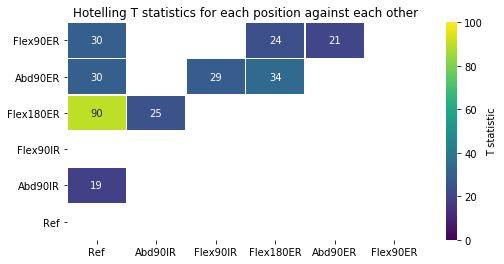

In [12]:
spm_heatmap(H_heatmap, title='Hotelling T statistics for each position against each other',
            labels=names_positions, save_fig=True, cmap='viridis', limits=[0, 100])

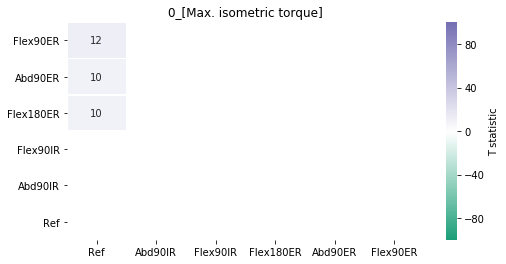

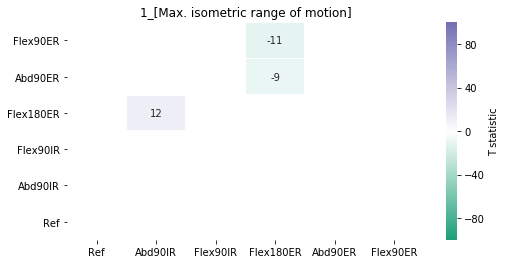

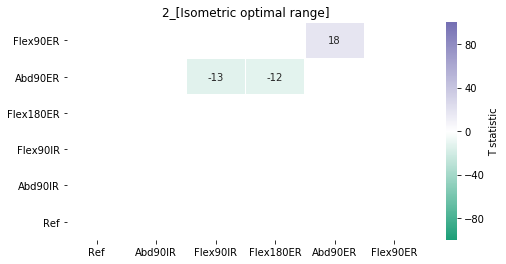

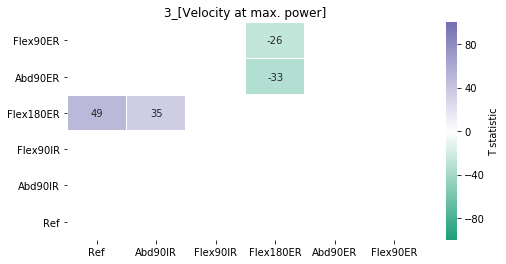

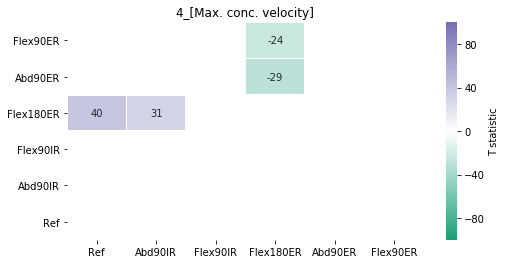

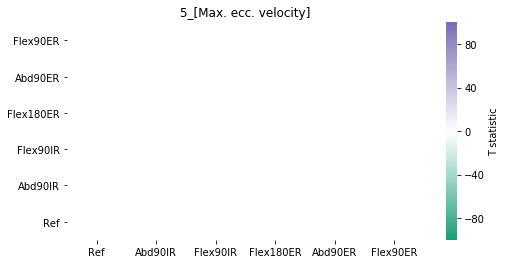

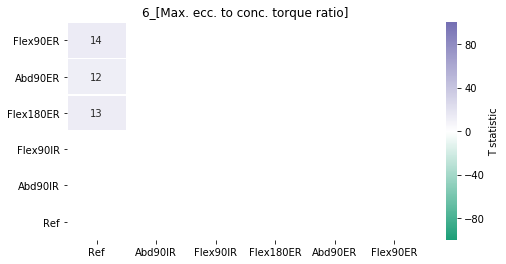

In [13]:
limits = [-100, 100]
colors = ['#1b9e77', 'white', '#7570b3']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
for iparameter in range(nparameter):
    spm_heatmap(T_heatmap[:, :, iparameter], title=f'{iparameter}_[{names_parameters[iparameter]}]',
                labels=names_positions, save_fig=True, limits=limits, cmap=cmap)

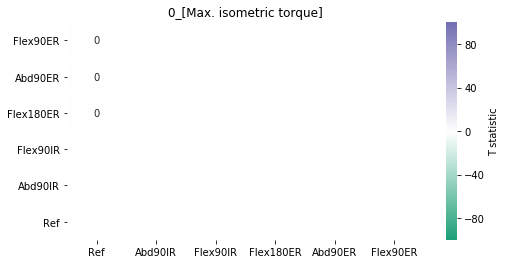

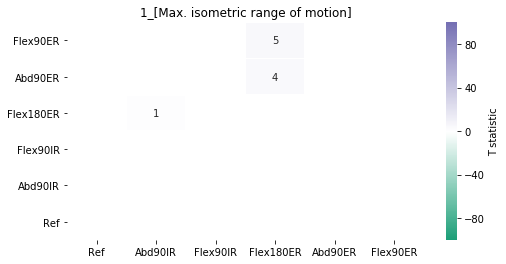

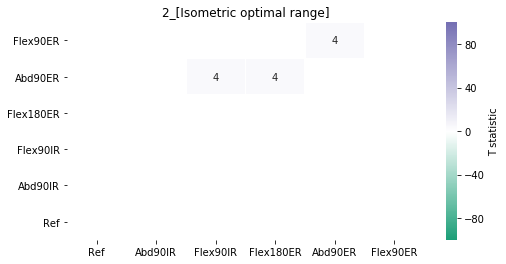

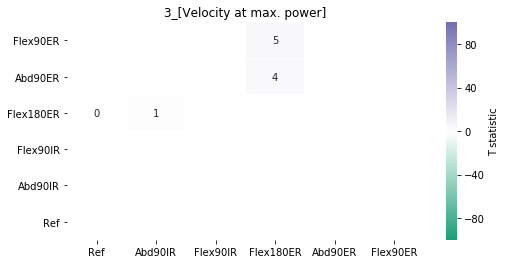

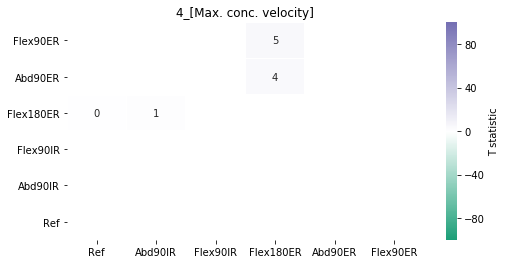

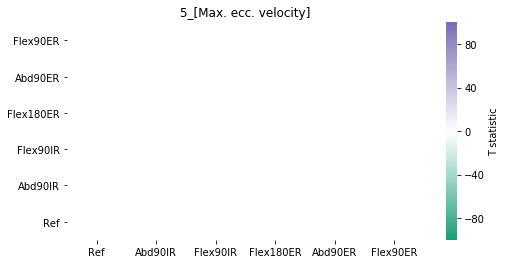

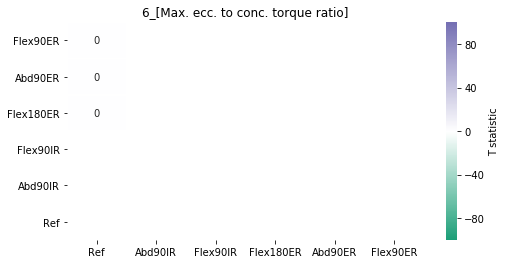

In [14]:
limits = [-100, 100]
colors = ['#1b9e77', 'white', '#7570b3']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
for iparameter in range(nparameter):
    spm_heatmap(ref_heatmap[:, :, iparameter], title=f'{iparameter}_[{names_parameters[iparameter]}]',
                labels=names_positions, save_fig=True, limits=limits, cmap=cmap)

In [15]:
names_positions

['Ref', 'Abd90IR', 'Flex90IR', 'Flex180ER', 'Abd90ER', 'Flex90ER']

In [16]:
sorted_parameters = {}
for iparameter in range(nparameter):
    print(f'parameter: {iparameter}')
    sorted_parameters[iparameter] = {}
    for iposition in range(n_positions):
#         print(f'\tposition: {names_positions[iposition]}')
        mean_by_position = y[positions == iposition, iparameter].mean()
#         print(f'\t\t{mean_by_position}')
        sorted_parameters[iparameter][names_positions[iposition]] = mean_by_position
        
    print(sorted(sorted_parameters[iparameter].items(), key=lambda x: x[1]))

parameter: 0
[('Flex90ER', 58.51570071139266), ('Abd90ER', 59.41779481680522), ('Flex180ER', 59.72604138324887), ('Flex90IR', 61.43558004513387), ('Abd90IR', 62.81924260328681), ('Ref', 65.72998610273841)]
parameter: 1
[('Flex180ER', 163.4839359031943), ('Ref', 169.48610265737986), ('Flex90IR', 178.96491039617183), ('Abd90ER', 179.81647077987262), ('Flex90ER', 183.7456712423679), ('Abd90IR', 183.9169477567909)]
parameter: 2
[('Flex90ER', 71.8477323320878), ('Flex90IR', 73.26648407102834), ('Flex180ER', 74.14644305153278), ('Ref', 78.1842534146807), ('Abd90IR', 81.18627596882821), ('Abd90ER', 85.04351387637472)]
parameter: 3
[('Flex180ER', 332.4694058076478), ('Flex90IR', 435.0364356281445), ('Abd90IR', 451.61821876799274), ('Flex90ER', 454.2019325184034), ('Ref', 496.8918281779567), ('Abd90ER', 501.66016869772324)]
parameter: 4
[('Flex180ER', 1063.7329995520797), ('Flex90IR', 1330.7407281772055), ('Abd90IR', 1396.1115433508148), ('Flex90ER', 1401.5945782611652), ('Ref', 1495.1956992953